<a href="https://colab.research.google.com/github/SterMoum/aqa-tests/blob/master/evaluation_NN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of different CNN Models


This notebook presents various CNN architectures and compares their training accuracies using the FashionMNIST dataset.

In [ ]:
# Import neccessary libraries
import torch, torchvision
from torchvision import datasets
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [ ]:
# Import torchmetrics for evaluation metrics
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "error"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"{mlxtend.__version__}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.9 MB/s eta 0:00:00
0.23.0


## 1. Data Preparation

The dataset that will be used for this project is the FashionMNIST dataset

https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST

In [ ]:
#Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_dataset = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15978562.43it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 278008.95it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4972401.70it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21106820.13it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
#Take a sample of the data
image, label = train_dataset[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

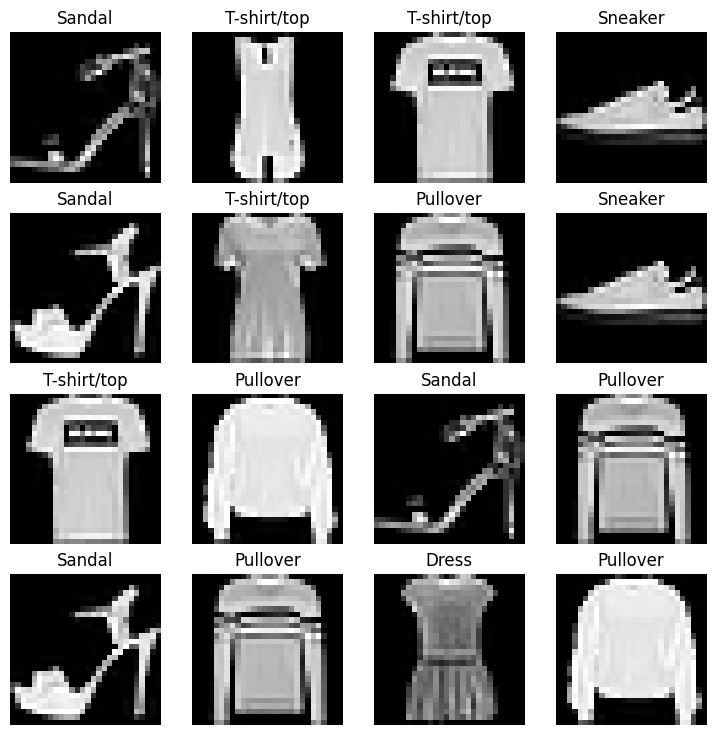

In [ ]:
#Visualze the data in random form

figure=plt.figure(figsize=(9,9))
nrows,ncols = 4, 4
for i in range(1, nrows * ncols + 1):
  random_idx = random.randint(1, len(class_names))
  image, label = train_dataset[random_idx]
  figure.add_subplot(nrows, ncols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)


In [ ]:
# Prepare the dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 2 Implementing train, test and evaluation functions

In [ ]:
# Initialing the evaluation metrics
from torchmetrics import Accuracy,F1Score

f1_score = F1Score(task="multiclass", num_classes=len(class_names)).to(device)
accuracy = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [ ]:
# Train Function
def train_step(model: torch.nn.Module,
               train_dataloader: DataLoader,
               optim: torch.optim,
               loss_fn: torch.nn.Module,
               device: torch.device):
  """Perform a train step for an epoch"""

  train_loss, train_acc, train_f1 = 0, 0, 0
  model.train()

  for batch, (X_train,y_train) in enumerate(train_dataloader):

    X_train, y_train = X_train.to(device), y_train.to(device)

    y_logits = model(X_train)

    loss = loss_fn(y_logits, y_train)

    train_loss += loss
    train_acc += accuracy(y_logits.argmax(dim=1), y_train)
    train_f1 += f1_score(y_logits.argmax(dim=1), y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  train_f1 /= len(train_dataloader)

  print(f"Train Loss:{train_loss:.5f} | Train Accuracy:{train_acc}% | Training F1 Score:{train_f1}%")


In [ ]:
# Test Function
def test_step(model: torch.nn.Module,
              test_dataloader: DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  """Perform a test step for an epoch"""

  test_loss, test_acc, test_f1 = 0, 0, 0

  model.eval()
  with torch.inference_mode():
    for (X_test,y_test) in test_dataloader:
      X_test,y_test = X_test.to(device), y_test.to(device)

      y_logits = model(X_test)

      loss = loss_fn(y_logits, y_test)

      test_loss += loss
      test_acc += accuracy(y_logits.argmax(dim=1), y_test)
      test_f1 += f1_score(y_logits.argmax(dim=1), y_test)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_f1 /= len(test_dataloader)

    print(f"Test Loss:{test_loss:.5f} | Test Accuracy:{test_acc}% | Testing F1 Score:{test_f1}%")


In [ ]:
def eval_model(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
               device):
  """Return a dict containing the results of model predicting on data_loader."""

  loss, acc, f1 = 0, 0, 0
  model.eval()
  with torch.inference_mode():
    for (X_test, y_test) in tqdm(test_dataloader):

      X_test,y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      loss += loss_fn(test_pred, y_test)
      acc += accuracy(test_pred.argmax(dim=1), y_test)
      f1 += f1_score(test_pred.argmax(dim=1), y_test)

    # Scale loss and acc to find average loss/acc per batch
    loss /= len(test_dataloader)
    acc /= len(test_dataloader)
    f1 /= len(test_dataloader)

  return {"model_name" : model.__class__.__name__,
          "model_loss" : loss.item(),
          "model_acc" : acc,
          "model_f1_score" : f1}

## TinyVGG Architecture

Implementing a NN according to the VGG architecture in the site: https://poloclub.github.io/cnn-explainer/

In [ ]:
class VGGModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    # 1st Convolutional Block
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    # 2nd Convolutional Block
    self.conv_block_2 = nn.Sequential(
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    # Classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*4*4,
                  out_features=output_shape)

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)

    return x

# VGG model creation
torch.manual_seed(42)

model_VGG = VGGModel(1, 20, len(class_names)).to(device)
random_tensor = torch.randn(size=(32, 1 , 28, 28)).to(device)
model_VGG(random_tensor).shape

torch.Size([32, 10])

## ResNet Architecture
Creation of a NN model according to ResNet Architecture using the pre-trained models of PyTorch

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
torch.manual_seed(42)

# ResNet model creation
weights = ResNet18_Weights.DEFAULT
model_Resnet = resnet18(weights=weights)

#ResNet uses in its first convolutional layerr 3 colour channels, while the FashionMNIST is consisted by data with 1 colour channel
model_Resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_Resnet.fc = nn.Linear(in_features=512, out_features=len(class_names),bias=True)
model_Resnet = model_Resnet.to(device)
model_Resnet

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Perform Training and Testing to the models

In [ ]:
# Perform Train and test to the VGG model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_VGG.parameters(), lr=0.1)

epochs = 10 # Train and test the model for 5 epochs
train_start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"----- Epoch {epoch+1} out of {epochs} -----")
  train_step(model=model_VGG,
             train_dataloader=train_dataloader,
             optim=optim,
             loss_fn=loss_fn,
             device=device)
  test_step(model=model_VGG,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

train_end_time = timer()
print(f"Total Training Time on {device} is {train_end_time - train_start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 1 out of 10 -----
Train Loss:0.62332 | Train Accuracy:0.768416702747345% | Training F1 Score:0.768416702747345%
Test Loss:0.43498 | Test Accuracy:0.8434504866600037% | Testing F1 Score:0.8434504866600037%
----- Epoch 2 out of 10 -----
Train Loss:0.38702 | Train Accuracy:0.8589000105857849% | Training F1 Score:0.8589000105857849%
Test Loss:0.38171 | Test Accuracy:0.8641173839569092% | Testing F1 Score:0.8641173839569092%
----- Epoch 3 out of 10 -----
Train Loss:0.33745 | Train Accuracy:0.8759333491325378% | Training F1 Score:0.8759333491325378%
Test Loss:0.35046 | Test Accuracy:0.8746006488800049% | Testing F1 Score:0.8746006488800049%
----- Epoch 4 out of 10 -----
Train Loss:0.31214 | Train Accuracy:0.8865833282470703% | Training F1 Score:0.8865833282470703%
Test Loss:0.32021 | Test Accuracy:0.8828873634338379% | Testing F1 Score:0.8828873634338379%
----- Epoch 5 out of 10 -----
Train Loss:0.29434 | Train Accuracy:0.8935500383377075% | Training F1 Score:0.8935500383377075%


In [ ]:
# Perform Train and test to the VGG model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_Resnet.parameters(), lr=0.001)

epochs = 10 # Train and test the model for 5 epochs
train_start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"----- Epoch {epoch+1} out of {epochs} -----")
  train_step(model=model_Resnet,
             train_dataloader=train_dataloader,
             optim=optim,
             loss_fn=loss_fn,
             device=device)
  test_step(model=model_Resnet,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

train_end_time = timer()
print(f"Total Training Time on {device} is {train_end_time - train_start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 1 out of 10 -----
Train Loss:0.73827 | Train Accuracy:0.7328500151634216% | Training F1 Score:0.7328500151634216%
Test Loss:0.48623 | Test Accuracy:0.8216853141784668% | Testing F1 Score:0.8216853141784668%
----- Epoch 2 out of 10 -----
Train Loss:0.49270 | Train Accuracy:0.8218500018119812% | Training F1 Score:0.8218500018119812%
Test Loss:0.41920 | Test Accuracy:0.8479432463645935% | Testing F1 Score:0.8479432463645935%
----- Epoch 3 out of 10 -----
Train Loss:0.42443 | Train Accuracy:0.8457333445549011% | Training F1 Score:0.8457333445549011%
Test Loss:0.38440 | Test Accuracy:0.8616213798522949% | Testing F1 Score:0.8616213798522949%
----- Epoch 4 out of 10 -----
Train Loss:0.38334 | Train Accuracy:0.8597000241279602% | Training F1 Score:0.8597000241279602%
Test Loss:0.36121 | Test Accuracy:0.8683106899261475% | Testing F1 Score:0.8683106899261475%
----- Epoch 5 out of 10 -----
Train Loss:0.35129 | Train Accuracy:0.87131667137146% | Training F1 Score:0.87131667137146%
Te

## Make Predictions and get Models` Results

In [ ]:
# For the VGG
torch.manual_seed(42)

model_VGG_results = eval_model(model_VGG, test_dataloader,loss_fn,device)
model_VGG_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'VGGModel',
 'model_loss': 0.3036174476146698,
 'model_acc': tensor(0.8925),
 'model_f1_score': tensor(0.8925)}

In [ ]:
# For the resnet
torch.manual_seed(42)

model_Resnet_results = eval_model(model_Resnet, test_dataloader,loss_fn,device)
model_Resnet_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.31659525632858276,
 'model_acc': tensor(0.8864, device='cuda:0'),
 'model_f1_score': tensor(0.8864, device='cuda:0')}